In [1]:
%matplotlib inline
from utils import *

from sklearn import*
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [42]:
eps = 1e-12
##########################################################################################################
class DATA(object):    
    # ---------------------------------------------------------------------------------------------------   
    def __init__(self, database_name, target, features, records_numbers=None):  
        self.data = list()
        self.X = list()
        self.Y = list()

        if records_numbers is None:
            folder_path = os.path.dirname( get_dataset_file_path(database_name,'') )
            file_path_list = list(Path(folder_path).glob('*.pkl'))     
        else:
            file_path_list = [get_dataset_file_path(database_name, 'record_'+"{0:0=2d}".format(n)) for n in records_numbers]
            
        for file_path in file_path_list:
            df = pd.read_pickle( file_path )  
            x = df.filter(regex=features, axis=1).values
#             y = df.filter(regex=target, axis=1).values
            y = np.mean(df.filter(regex=target, axis=1).values, axis=1)
            
            # lists
            self.data.append( df )
            self.X.append( x )
            self.Y.append( y.reshape((len(y))) )

        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        return           
    # ---------------------------------------------------------------------------------------------------   
    def mtx( self, Nt_mtx='max' ):  
        # This function padds or cuts all input data (X) to make them same length and generate matrix data(X_mtx)
        # it also nomalize data X-mean(X)
        data_mtx = copy.deepcopy(self)
        if len(np.shape(data_mtx.X))>1:  return data_mtx    

        Nt_list = [np.shape(x)[0] for x in self.X]
        Nt = int( eval('np.' + Nt_mtx)(Nt_list) )
        Nd, Nf = len(self.X),  np.shape(self.X[0])[1]
        
        data_mtx.X = np.zeros( (Nd,Nt,Nf) )
        data_mtx.Y = np.zeros( (Nd,Nt) )
        
        for idx, x in enumerate(self.X): 
            nt = np.shape(x)[0]
            
            if Nt >= nt:
                data_mtx.X[idx,:,:] = np.pad( x, ((0,Nt-nt),(0,0)),'constant')
                data_mtx.Y[idx,:nt] = self.Y[idx]
                
            else:
                data_mtx.X[idx,:,:] = x[:Nt,:]
                data_mtx.Y[idx, :] = self.Y[idx][:Nt]
        return data_mtx
    # ---------------------------------------------------------------------------------------------------
    def segment(self, win_size=None, step=1, as_one=True):
        if step is None: step= win_size
        
        segmented_data = copy.deepcopy(self)
        for i,(x,y) in enumerate(zip(self.X, self.Y)):            
            segmented_data.X[i] = np.array([ x[i:i+win_size].flatten() for i in range(0, len(x)-win_size+1, step) ])
            segmented_data.Y[i] = np.array(y[win_size-1::step])
        
        if as_one:
            segmented_data.X = np.concatenate(segmented_data.X)
            segmented_data.Y = np.concatenate(segmented_data.Y)

        return segmented_data
    # ---------------------------------------------------------------------------------------------------         

#### Load Data

In [43]:
target = 'distance' 
features = 'rssi'

train_data = DATA('dataset_02', target, features)
validation_data = DATA('dataset_03', target, features)

print( "Train Data - X: \t", np.shape(train_data.X), np.shape(train_data.X[0]))
print( "Train Data - Y: \t", np.shape(train_data.Y), np.shape(train_data.Y[0]))
print( "Validation Data - X: \t", np.shape(validation_data.X), np.shape(validation_data.X[0]))
print( "Validation Data - Y: \t", np.shape(validation_data.Y), np.shape(validation_data.Y[0]))

Train Data - X: 	 (30,) (521, 2)
Train Data - Y: 	 (30,) (521,)
Validation Data - X: 	 (18,) (430, 2)
Validation Data - Y: 	 (18,) (430,)


# sklearn

In [44]:
model = GradientBoostingRegressor(random_state=0)

In [45]:
win_size = 5
step = 1

train_data_segmented = train_data.segment(win_size, step)
validation_data_segmented = validation_data.segment(win_size, step, as_one=False)

In [46]:
model = GradientBoostingRegressor(random_state=0)
# model = make_pipeline(StandardScaler(), model)
model.fit( train_data_segmented.X, train_data_segmented.Y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

NRMSE= 1.08 %
NRMSE_smoothed= 1.04 %


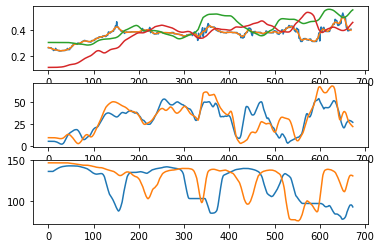

In [64]:
idx = 6
data_test = validation_data.data[idx]
x_test = validation_data_segmented.X[idx]
y_test = validation_data_segmented.Y[idx]

preds = model.predict(x_test)
preds_smooth = signal.savgol_filter( preds, window_length=11, polyorder=1)            

# r2 = model.score(train_data_segmented.X, train_data_segmented.Y)
print('NRMSE=', np.round(mean_squared_error( y_test, preds ) / np.mean(y_test) * 100, 2), '%' )
print('NRMSE_smoothed=', np.round(mean_squared_error( y_test, preds_smooth ) / np.mean(y_test) * 100, 2), '%' )


# plt.plot(validation_data_segmented.Y[idx])
# plt.plot(preds)
# plt.plot(preds_smooth)
# plt.show()

plt.subplot(311)
plt.plot(preds)
plt.plot(preds_smooth)
plt.plot(data_test.distance_0.values)
plt.plot(data_test.distance_1.values)

plt.subplot(312)
plt.plot(data_test.misalignment_0.values)
plt.plot(data_test.misalignment_1.values)

plt.subplot(313)
plt.plot(data_test.rssi_0.values)
plt.plot(data_test.rssi_1.values)


In [19]:
class REGRESSOR(object):
    
    def __init__(self, model, win_size, step=1):
        np.random.seed(7)        
        
        self.model = model                
        self.win_size = win_size
        self.step = step                
            
    
    def train(self, train_data, win_size, step=None):        
        for i in range(0, np.shape(train_data.X)[1]-self.win_size, self.step):
                history = self.model.fit( 
                    train_data.X[:, i:i+self.win_size,:], 
                    train_data.Y[:, i+self.win_size-1], 
                    epochs = 1, 
                    verbose = verbose
                )    
                ep_loss.append(history.history['loss'])
            
            loss.append(ep_loss)
            clear_output(wait=True)
        loss = np.array(loss)
        
        if show:
            plt.plot( np.ndarray.flatten(loss) )
            plt.show()
        return loss

    
    def predict(self, X):
        predictions = list()
        for i in range(0, np.shape(X)[1]-self.win_size, self.step):
            pred = self.model.predict( X[:, i:i+self.win_size,:])
            predictions.append(pred)
        
        predictions = np.array(predictions)
        return predictions.reshape((-1, np.shape(predictions)[1])).transpose()  
    
    
    def build_model(self, Nunits=5, Nlayers=2, Nfeatures=2, activation='tanh', optimizer='adam', loss='mse'):
        self.model = keras.models.Sequential()   
        
        if Nlayers>1:
            self.model.add( keras.layers.LSTM(Nunits, return_sequences=True, input_shape=(self.win_size, Nfeatures)))        
            for n in range(Nlayers-2): 
                self.model.add( keras.layers.LSTM(Nunits, return_sequences=True))  
            self.model.add( keras.layers.LSTM(Nunits, return_sequences=False))   
        else:
            self.model.add( keras.layers.LSTM(Nunits, return_sequences=False, input_shape=(self.win_size, Nfeatures)))        

        self.model.add( keras.layers.Dense(1, activation=activation))  
        
        self.model.compile(loss=loss, optimizer=optimizer) 
        
        print(self.model.summary())        
        return 

